In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

FRAC_ADMIT = 0.5


In [19]:


###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test_large.csv')
df['key'] = df['R'].astype(str) + "_"  + df['T'].astype(str)



In [20]:
df['Y_stratum'] = df['Y'].astype(str) + df['Y_reject'].astype(str)



In [21]:
###
## Get number of people in each stratum
###

dff = df[['R','T','key','Y','Y_reject']].groupby(['R','T','Y','Y_reject']).count().reset_index()
dff.columns = ['R','T','Y','Y_reject','N']

In [23]:
TOTAL_ADMITS = int(len(df)*FRAC_ADMIT)
MAX_BLACK_ADMITS = len(df[df['R']==1])
MIN_GRADUATES = 100000
GRID_SIZE = 1000

outcomes_grid = []
Xs = []
Ys = []

for N_black_admits in range(0,MAX_BLACK_ADMITS):
    
    if N_black_admits % GRID_SIZE != 0:
        continue
    
    black_admits = df[df['R']==1].sort_values(by='T',ascending=False).head(n=N_black_admits)
    white_admits = df[df['R']==0].sort_values(by='T',ascending=False).head(n=TOTAL_ADMITS-N_black_admits)
    
    Y = black_admits['Y'].sum() + white_admits['Y'].sum()
    
    Xs.append(N_black_admits)
    Ys.append(Y)
    print(N_black_admits,Y)
    
    for y_iter in np.arange(MIN_GRADUATES,Y,GRID_SIZE):
        outcomes_grid.append({'min_black_admits':N_black_admits-GRID_SIZE/2, 'max_black_admits':N_black_admits+GRID_SIZE/2, 'max_graduates':y_iter+GRID_SIZE, 'min_graduates':y_iter, 'policy_exists':'Unknown'})
        

0 292771
1000 293348
2000 293869
3000 294373
4000 294798
5000 295246
6000 295660
7000 296067
8000 296473
9000 296863
10000 297254
11000 297612
12000 297963
13000 298332
14000 298691
15000 299019
16000 299365
17000 299667
18000 299977
19000 300274
20000 300568
21000 300856
22000 301149
23000 301406
24000 301673
25000 301924
26000 302174
27000 302462
28000 302734
29000 302941
30000 303165
31000 303348
32000 303581
33000 303755
34000 303969
35000 304170
36000 304380
37000 304610
38000 304814
39000 305001
40000 305189
41000 305359
42000 305546
43000 305716
44000 305887
45000 306035
46000 306188
47000 306365
48000 306461
49000 306562
50000 306691
51000 306796
52000 306912
53000 307067
54000 307204
55000 307327
56000 307411
57000 307470
58000 307578
59000 307711
60000 307862
61000 307962
62000 308027
63000 308129
64000 308193
65000 308294
66000 308358
67000 308430
68000 308527
69000 308531
70000 308594
71000 308653
72000 308687
73000 308706
74000 308737
75000 308773
76000 308830
77000 308870

In [24]:
df_pareto = pd.DataFrame({'# Black Admits':Xs, '# Graduates':Ys})

### Setup optimization problem 

In [25]:
from ortools.linear_solver import pywraplp


In [26]:
solver = pywraplp.Solver.CreateSolver('GLOP')


In [27]:
len(dff[['R','T','Y','Y_reject']])

568

In [28]:
dff

,R,T,Y,Y_reject,N
0,0,8,0,0,1
1,0,9,0,0,2
2,0,10,0,0,1
3,0,11,0,0,4
4,0,12,0,0,4
...,...,...,...,...,...
563,1,105,1,1,1
564,1,107,0,0,1
565,1,107,1,1,1
566,1,109,1,1,2


In [29]:
applicant_stratum = []
vars_cache = {}

# Objective: Maximize the expected utility of the admitted students
objective = solver.Objective()

# For each stratum
for ix, row in dff.iterrows():
    # probability of admission
    numvar = solver.NumVar(0.0, 1.0, str(ix))
    
    # store variable by index, and also by stratum R, T
    applicant_stratum.append(numvar)
    vars_cache[(row['R'],row['T'],row['Y'], row['Y_reject'])] = numvar
    
    # Benefit of admitting people is total utility in that stratum
    objective.SetCoefficient(applicant_stratum[ix], float(row['N']))
objective.SetMaximization()


In [30]:
# Currently we have no constraints 
solver.NumConstraints()

0

In [31]:
# Constraint: At most K applicants
K = int(len(df)*FRAC_ADMIT)
print(K)
admit_quota = solver.Constraint(0, K)

# Total applicants cannot exceed K 
for ix, row in dff.iterrows():
    admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))

500000


In [32]:
# Now we have one constraint
solver.NumConstraints()

1

## Add Equalized Odds Constraints

In [33]:
## Make sure that you have to add all people in Y stratum or none
## i.e. you can't add only people who pass boards and reject those who fail boards from same T, R stratum
didntexist, exists = 0, 0 

for ix, row in dff.iterrows():
    
    
    var1 = vars_cache[(row['R'],row['T'],row['Y'], row['Y_reject'])]
    key2s = [(row['R'],row['T'], 1-row['Y'], 1-row['Y_reject']), (row['R'],row['T'], row['Y'], 1-row['Y_reject']), (row['R'],row['T'], 1-row['Y'], row['Y_reject'])]
    
    for key2 in key2s:
        constrain_bp = solver.Constraint(0.0, 0.0)
        
        if key2 not in vars_cache:
            didntexist+=1
            continue
            
        var2 = vars_cache[key2]
        
        constrain_bp.SetCoefficient(var1, -1.0)
        constrain_bp.SetCoefficient(var2, 1.0)
        exists+=1

didntexist, exists

(680, 1024)

In [34]:
majority_pass_boards_pass_boards_reject = []
majority_fail_boards_pass_boards_reject = []
minority_pass_boards_pass_boards_reject = []
minority_fail_boards_pass_boards_reject = []
majority_pass_boards_fail_boards_reject = []
majority_fail_boards_fail_boards_reject = []
minority_pass_boards_fail_boards_reject = []
minority_fail_boards_fail_boards_reject = []


for key in vars_cache:
    r, t, Y, Y_reject = key
    if Y == 1 and r==0 and Y_reject==1:
        majority_pass_boards_pass_boards_reject.append(key)
    elif Y == 0 and r==0 and Y_reject==1:
        majority_fail_boards_pass_boards_reject.append(key)
    elif Y == 1 and r==1 and Y_reject==1:
        minority_pass_boards_pass_boards_reject.append(key)
    elif Y == 0 and r==1 and Y_reject==1:
        minority_fail_boards_pass_boards_reject.append(key)
        
    if Y == 1 and r==0 and Y_reject==0:
        majority_pass_boards_fail_boards_reject.append(key)
    elif Y == 0 and r==0 and Y_reject==0:
        majority_fail_boards_fail_boards_reject.append(key)
    elif Y == 1 and r==1 and Y_reject==0:
        minority_pass_boards_fail_boards_reject.append(key)
    elif Y == 0 and r==1 and Y_reject==0:
        minority_fail_boards_fail_boards_reject.append(key)

len(majority_pass_boards_pass_boards_reject),len(majority_fail_boards_pass_boards_reject),len(minority_pass_boards_pass_boards_reject),len(minority_fail_boards_pass_boards_reject)




(114, 0, 96, 0)

In [35]:
NUM_TOTALS = {}
df_totals = dff[['N','R','Y','Y_reject']].groupby(['R','Y','Y_reject']).sum().reset_index()
for ix, row in df_totals.iterrows():
    NUM_TOTALS[(row['R'],row['Y'],row['Y_reject'])] = row['N']
    
N_IN_STRATAS = {}
for ix, row in dff.iterrows():
    N_IN_STRATAS[(row['R'],row['T'],row['Y'],row['Y_reject'])] = row['N']

In [36]:
# Now we have one constraint
solver.NumConstraints()

1705

In [37]:
#Of those who pass the boards exams, pass boards exams if rejected
#Frac majority admitted and frac minority admitted should be the same

constrain_pass_boards_pass_boards_reject = solver.Constraint(0.0, 0.0)

for key in majority_pass_boards_pass_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_pass_boards_pass_boards_reject.SetCoefficient(vars_cache[key], float(N_IN_STRATUM) / float(N_TOTAL))

for key in minority_pass_boards_pass_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_pass_boards_pass_boards_reject.SetCoefficient(vars_cache[key], -1.0 * (float(N_IN_STRATUM) / float(N_TOTAL)))


In [38]:
#Of those who fail the boards exams, pass boards exams if rejected
#Frac majority admitted and frac minority admitted should be the same

constrain_fail_boards_pass_boards_reject = solver.Constraint(0.0, 0.0)

for key in majority_fail_boards_pass_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_fail_boards_pass_boards_reject.SetCoefficient(vars_cache[key], float(N_IN_STRATUM) / float(N_TOTAL))

for key in minority_fail_boards_pass_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_fail_boards_pass_boards_reject.SetCoefficient(vars_cache[key], -1.0 * (float(N_IN_STRATUM) / float(N_TOTAL)))


In [39]:
constrain_pass_boards_fail_boards_reject = solver.Constraint(0.0, 0.0)

for key in majority_pass_boards_fail_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_pass_boards_fail_boards_reject.SetCoefficient(vars_cache[key], float(N_IN_STRATUM) / float(N_TOTAL))

for key in minority_pass_boards_fail_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_pass_boards_fail_boards_reject.SetCoefficient(vars_cache[key], -1.0 * (float(N_IN_STRATUM) / float(N_TOTAL)))

    
#Of those who fail the boards exams, fail boards exams if rejected
#Frac majority admitted and frac minority admitted should be the same

constrain_fail_boards_fail_boards_reject = solver.Constraint(0.0, 0.0)

for key in majority_fail_boards_fail_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_fail_boards_fail_boards_reject.SetCoefficient(vars_cache[key], float(N_IN_STRATUM) / float(N_TOTAL))

for key in minority_fail_boards_fail_boards_reject:
    r, t, Y, Y_reject = key
    N_IN_STRATUM = N_IN_STRATAS[(r,t,Y, Y_reject)]
    N_TOTAL = NUM_TOTALS[(r,Y, Y_reject)]
    
    constrain_fail_boards_fail_boards_reject.SetCoefficient(vars_cache[key], -1.0 * (float(N_IN_STRATUM) / float(N_TOTAL)))


## Add outcome constraints

In [40]:
constrain_graduate = solver.Constraint(0, 0)

for ix, row in dff.iterrows():
    
    key = (row['R'],row['T'],row['Y'],row['Y_reject'])
    n_graduate = row['Y'] * row['N']
    constrain_graduate.SetCoefficient(vars_cache[key], float(n_graduate))

constrain_black_admit = solver.Constraint(0, 0)

for ix, row in dff.iterrows():
    key = (row['R'],row['T'],row['Y'],row['Y_reject'])
    n_black = row['R'] * row['N']
    constrain_black_admit.SetCoefficient(vars_cache[key], float(n_black))


## Solve linear program

In [41]:
count = 0 

print ('Total grid cells to check: {}'.format(len(outcomes_grid)))

for region in outcomes_grid:
    constrain_graduate.SetBounds(float(region['min_graduates']), float(region['max_graduates']))
    constrain_black_admit.SetBounds(float(region['min_black_admits']), float(region['max_black_admits']))
    status = solver.Solve()
    if status == 0:
        region['policy_exists'] = 1
        
        row = []
        admit = []

        for i in applicant_stratum:
            row.append(int(str(i)))
            admit.append(i.solution_value())
        #df_decisions = pd.DataFrame({'row_id':row,'decision':admit})
        region['policy'] = (row,admit)    
    else:
        continue
        #print(status)
        
    count+=1
    
    if count % 100 ==0:
        print ('Total grid cells checked so far: {}/{}'.format(count,len(outcomes_grid)))




Total grid cells to check: 63021
Total grid cells checked so far: 100/63021
Total grid cells checked so far: 200/63021
Total grid cells checked so far: 300/63021
Total grid cells checked so far: 400/63021
Total grid cells checked so far: 500/63021
Total grid cells checked so far: 600/63021
Total grid cells checked so far: 700/63021
Total grid cells checked so far: 800/63021
Total grid cells checked so far: 900/63021
Total grid cells checked so far: 1000/63021
Total grid cells checked so far: 1100/63021
Total grid cells checked so far: 1200/63021
Total grid cells checked so far: 1300/63021
Total grid cells checked so far: 1400/63021
Total grid cells checked so far: 1500/63021
Total grid cells checked so far: 1600/63021
Total grid cells checked so far: 1700/63021
Total grid cells checked so far: 1800/63021
Total grid cells checked so far: 1900/63021
Total grid cells checked so far: 2000/63021
Total grid cells checked so far: 2100/63021
Total grid cells checked so far: 2200/63021
Total gr

In [46]:
import pickle 
file = open("Fruits.obj",'rb')
outcomes_grid2 = pickle.load(file)
file.close()


In [47]:
dn = pd.read_csv('./lp_results.csv',sep='\t')

dn


,Policy Name,Frac Diverse Candidates,Total Graduated
0,Random,0.333515,21859.000000
1,Maximize Utility,0.381300,29476.446379
2,Counterfactual Fairness,0.332824,22021.879847
3,Path-Specific Fairness,0.332654,22037.819067
4,Counterfactual Equalized Odds,0.308245,29945.658086
5,Principal Fairness,0.308358,29534.758747
6,Counterfactual Pred. Parity,0.555653,25032.000000
7,Principal Fairness,0.306796,293445.544045
8,Counterfactual Equalized Odds,0.305994,299244.972711


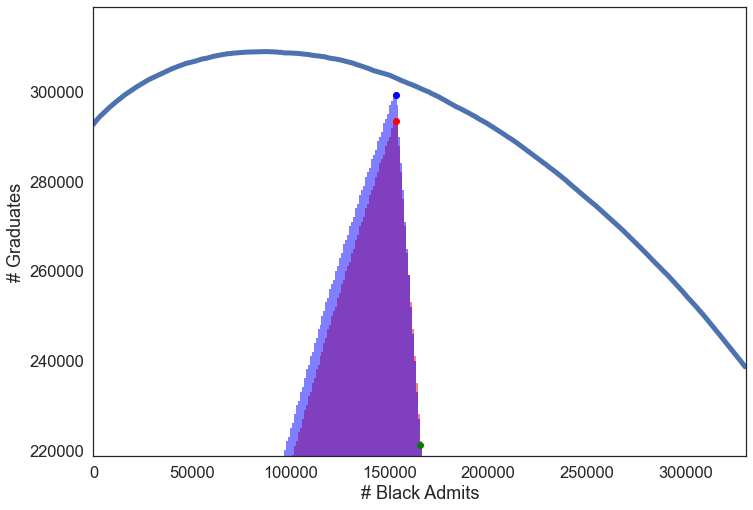

In [48]:
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white", font_scale=1.5, )
ax = sns.lineplot(data=df_pareto, x='# Black Admits', y='# Graduates',linewidth=5)
errorboxes = []

for outcome_block in outcomes_grid:
    if outcome_block['policy_exists'] == 1:
        errorboxes.append(Rectangle((outcome_block['min_black_admits'] , outcome_block['min_graduates']),GRID_SIZE,GRID_SIZE))

pc = PatchCollection(errorboxes, facecolor='red', alpha=0.5,  edgecolor='none')
                       
ax.add_collection(pc)

errorboxes2 = []

for outcome_block in outcomes_grid2:
    if outcome_block['policy_exists'] == 1:
        errorboxes2.append(Rectangle((outcome_block['min_black_admits'] , outcome_block['min_graduates']),GRID_SIZE,GRID_SIZE))

pc2 = PatchCollection(errorboxes2, facecolor='blue', alpha=0.5,  edgecolor='none')
                       
ax.add_collection(pc2)


plt.scatter(x=(df['R']*0.5).sum(),y=(df['Y']*0.5).sum(),color='green')   
plt.scatter(x=0.306796*len(df)*FRAC_ADMIT,y=293445.544045,color='red')   
plt.scatter(x=0.305994*len(df)*FRAC_ADMIT,y=299244.972711,color='blue')   

plt.xlim([0, MAX_BLACK_ADMITS])
plt.ylim([df_pareto['# Graduates'].min()-20000, df_pareto['# Graduates'].max()+10000])
plt.show()


    


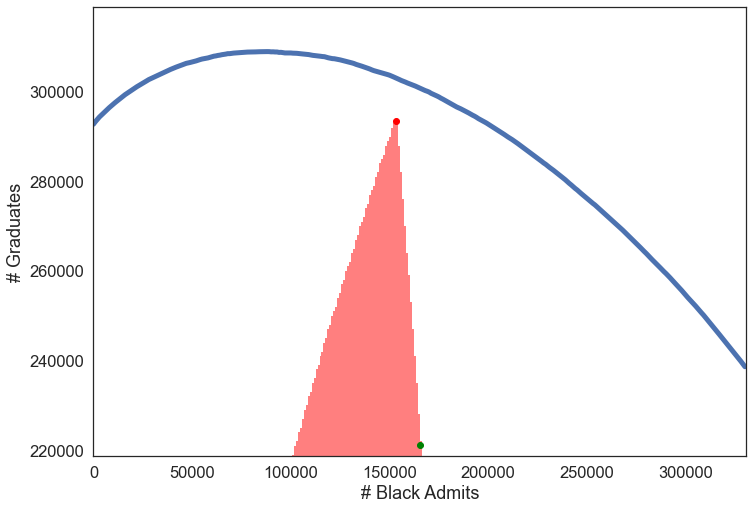

In [45]:
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white", font_scale=1.5, )
ax = sns.lineplot(data=df_pareto, x='# Black Admits', y='# Graduates',linewidth=5)
errorboxes = []

for outcome_block in outcomes_grid:
    if outcome_block['policy_exists'] == 1:
        errorboxes.append(Rectangle((outcome_block['min_black_admits'] , outcome_block['min_graduates']),GRID_SIZE,GRID_SIZE))

pc = PatchCollection(errorboxes, facecolor='red', alpha=0.5,  edgecolor='none')
                       
ax.add_collection(pc)



plt.scatter(x=(df['R']*0.5).sum(),y=(df['Y']*0.5).sum(),color='green')   
plt.scatter(x=0.306796*len(df)*FRAC_ADMIT,y=293445.544045,color='red')   

plt.xlim([0, MAX_BLACK_ADMITS])
plt.ylim([df_pareto['# Graduates'].min()-20000, df_pareto['# Graduates'].max()+10000])
plt.show()


    


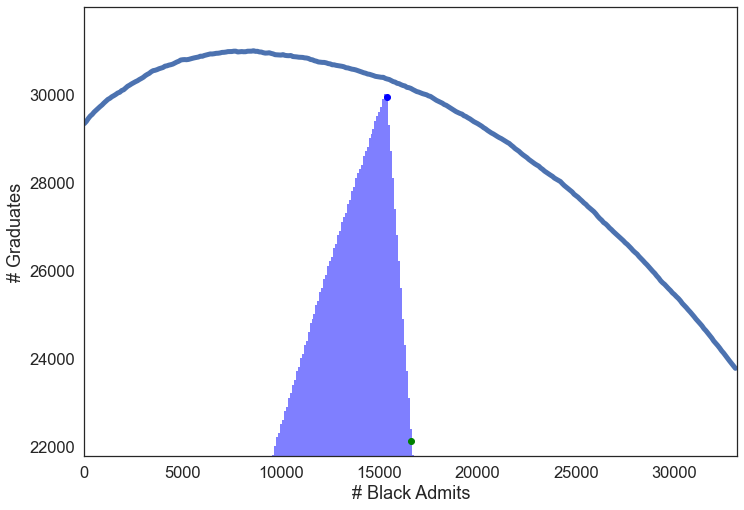

In [34]:
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white", font_scale=1.5, )
ax = sns.lineplot(data=df_pareto, x='# Black Admits', y='# Graduates',linewidth=5)

errorboxes2 = []

for outcome_block in outcomes_grid2:
    if outcome_block['policy_exists'] == 1:
        errorboxes2.append(Rectangle((outcome_block['min_black_admits'] , outcome_block['min_graduates']),GRID_SIZE,GRID_SIZE))

pc2 = PatchCollection(errorboxes2, facecolor='blue', alpha=0.5,  edgecolor='none')
                       
ax.add_collection(pc2)


plt.scatter(x=(df['R']*0.5).sum(),y=(df['Y']*0.5).sum(),color='green')   
plt.scatter(x=0.308245*len(df)*FRAC_ADMIT,y=29945.658086,color='blue')   

plt.xlim([0, MAX_BLACK_ADMITS])
plt.ylim([df_pareto['# Graduates'].min()-2000, df_pareto['# Graduates'].max()+1000])
plt.show()


    
